# Generative Diffusion Model for MNIST Digits

In 2020, researchers from UC Berkeley released their paper *Denoising Diffusion Probabilistic Models* on a generative machine learning architecture called a diffusion model. (https://arxiv.org/abs/2006.11239)

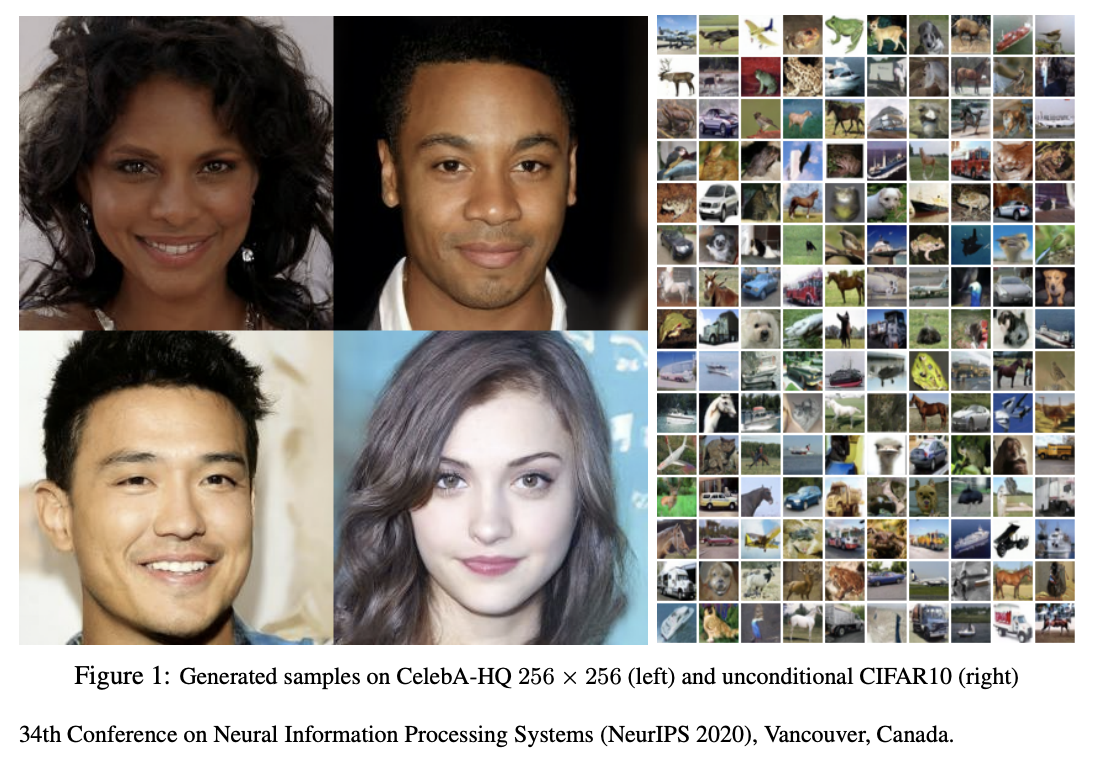

These models are based on nonequilibrium thermodynamics and seek to denoise images to create new realistic looking images.

## Imports

In [1]:
!pip install torchinfo

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import matplotlib as mpl
%matplotlib inline
import scipy
import os
import copy
from tqdm import tqdm#.notebook import tqdm
from time import time

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision
from torch import linalg
from torchvision.transforms import ToTensor
import torchinfo

torch.set_default_dtype(torch.float64)
plt.rcParams["font.family"] = 'sans-serif'
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


## Loading the Data: Let us begin with a simple example using MNIST digits

In [18]:
loaded_already = True

In [19]:
# Hyperparameters
batch_size = 32
image_size = 32

# Load MNIST dataset
transform = transforms.Compose([ transforms.Resize((image_size, image_size)), # resizes images
                                      transforms.ToTensor(), # Scales data into [0,1]
                                      transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
                                      ])

torch.manual_seed(0)
if loaded_already is not None:
  train_size = 10000
  train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
  # idx0 = torch.where(train_dataset.targets==0)[0]
  # idx1 = torch.where(train_dataset.targets==1)[0]
  # indxs = torch.cat([idx0,idx1])
  # train_dataset.targets = train_dataset.targets[indxs]
  # train_dataset.data = train_dataset.data[indxs]#/255.

  subset_indices = torch.randperm(len(train_dataset))[:train_size]
  subset_dataset = torch.utils.data.Subset(train_dataset, subset_indices)
  train_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)

  # test_size = 100
  # test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
  # subset_indices = torch.randperm(len(test_dataset))[:test_size]
  # subset_dataset = torch.utils.data.Subset(test_dataset, subset_indices)
  # test_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)

  loaded_already = None

Feature batch shape: torch.Size([32, 1, 32, 32])
Labels batch shape: torch.Size([32])


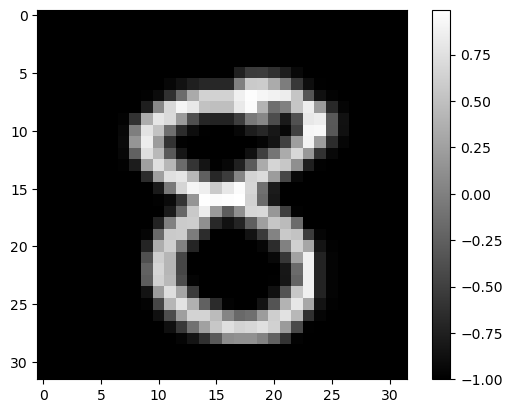

Label: 8


In [20]:
torch.manual_seed(0)
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# test_features, test_labels = next(iter(test_loader))

img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.colorbar()
plt.show()
print(f"Label: {label}")

## Setting up the Model

Components of the Diffusion Model:



1.   **Forward Noising Process:** This is a stochastic markov process which adds scheduled noise to the images sequentially depending on the previous image's state. We can express the noised image at time step $t$ by
$$q(x_t | x_{t-1}) = N(\sqrt{1- \beta_t}x_{t-1}, \sqrt{\beta_t}I) =  \sqrt{1- \beta_t}x_{t-1}+ \sqrt{\beta_t}\varepsilon $$
where $\varepsilon$ is the sampled noise from a normal distribution with a mean of zero and standard deviation about the identity, , i.e. $N(0,I)$, times the square root of $\beta_t$. The number of total time steps $T$ and the range of the $\beta$'s are hyperparameters chosen by the user. Typically, $\beta \in [10^{-4},0.02]$ and $T=1000$. One can precompute the noised image at any time step by using
$$x_t(x_0,\varepsilon) = \sqrt{\prod_{i=1}^t \alpha_i} x_0 + \sqrt{1-\prod_{i=1}^t \alpha_i} \varepsilon$$
where $\alpha_i = 1-\beta_i$.


2.   **Backwards Parameterized Denoising Process (U-Net):** A neural networks with learnable parameters to recover the original images from the diffused ones with noise. This architecture is typically a U-Net which is a convolutional neural network with convolutional layers to decrease the feature size (down layers) and convolutional transpose layers to increase the feature size (up layers). See the discussion section for how the convolutional transpose function works in practice.




In [21]:
# torch.autograd.set_detect_anomaly(True)
# U-Net model
class UNet(nn.Module):
    def __init__(self, time_emb_dim):
        super(UNet, self).__init__()
        # Encoders
        self.enc1 = nn.Conv2d(in_channels = 1, out_channels = time_emb_dim, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(in_channels = time_emb_dim,out_channels = time_emb_dim, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(in_channels = time_emb_dim,out_channels = time_emb_dim*2, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(in_channels = time_emb_dim*2,out_channels = time_emb_dim*2, kernel_size=3, padding=1)
        self.enc5 = nn.Conv2d(in_channels = time_emb_dim*2,out_channels = time_emb_dim*4, kernel_size=3, padding=1)
        # Decoders
        self.dec1 = nn.ConvTranspose2d(in_channels = time_emb_dim*4, out_channels = time_emb_dim*2, kernel_size=3, padding=1)
        self.dec2 = nn.ConvTranspose2d(in_channels = time_emb_dim*2, out_channels = time_emb_dim*2, kernel_size=3, padding=1)
        self.dec3 = nn.ConvTranspose2d(in_channels = time_emb_dim*2, out_channels = time_emb_dim, kernel_size=3, padding=1)
        self.dec4 = nn.ConvTranspose2d(in_channels = time_emb_dim, out_channels = time_emb_dim, kernel_size=3, padding=1)
        self.dec5 = nn.ConvTranspose2d(in_channels = time_emb_dim, out_channels = 1, kernel_size=3, padding=1)

        # further time MLPs
        self.time_mlp1 = nn.Sequential(nn.Linear(time_emb_dim, time_emb_dim*2),nn.ReLU())
        self.time_mlp2 = nn.Sequential(nn.Linear(time_emb_dim*2, time_emb_dim*2),nn.ReLU())
        self.time_mlp3 = nn.Sequential(nn.Linear(time_emb_dim*2, time_emb_dim),nn.ReLU())

    def forward(self, x, time):
        # Apply the encoders followed by the decoders
        '''
        Encoder 1: Block 1
        '''
        x = F.relu(self.enc1(x))
        x = x + time[None,:,None,None].to(device)
        # x = F.max_pool2d(input = x, kernel_size = 2)
        # 2
        x = F.relu(self.enc2(x))
        # Max pooling on the way down to a new block
        x = F.max_pool2d(input = x, kernel_size = 2)

        '''
        Encoder 2: Block 2
        '''
        # 3
        x = F.relu(self.enc3(x))
        # x = F.max_pool2d(input = x, kernel_size = 2)
        time = self.time_mlp1(time.to(device))
        x = x + time[None,:,None,None]
        # 4
        x = F.relu(self.enc4(x))
        # x = F.max_pool2d(input = x, kernel_size = 2)
        # 5
        x = F.relu(self.enc5(x))
        x = F.max_pool2d(input = x, kernel_size = 2)

        # Interpolation on the way up to next block
        x = F.interpolate(x, scale_factor=2)
        '''
        Decoder 1: Block 3
        '''
        x = F.relu(self.dec1(x))
        time = self.time_mlp2(time)
        x = x + time[None,:,None,None]
        # 2
        x = F.relu(self.dec2(x))
        # x = F.interpolate(x, scale_factor=2)
        # 3
        x = F.relu(self.dec3(x))
        x = F.interpolate(x, scale_factor=2)

        '''
        Decoder 2: Block 4
        '''
        # 4
        x = F.relu(self.dec4(x))
        time = self.time_mlp3(time)
        x = x + time[None,:,None,None]
        # x = F.interpolate(x, scale_factor=2)
        x = F.relu(self.dec5(x))
        # x = F.interpolate(x, scale_factor=2)
        return x

# Forward Diffusion Noising Process
class forward_noise(nn.Module):
    def __init__(self):
        super(forward_noise, self).__init__()

    def forward(self, x, T, t, betas):
        noise = torch.randn_like(x)
        alphas = 1. - betas # defining alpha vector
        alphas_cumprod = torch.cumprod(alphas, axis=0)  # cumulative product vector of the same size
        sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
        # for t in range(T):
        #     noise = torch.randn_like(x)
        #     x = torch.sqrt(1 - betas[t]) * x + torch.sqrt(betas[t]) * noise
        x = sqrt_alphas_cumprod[t]*x + sqrt_one_minus_alphas_cumprod[t]*noise
        return x, noise

# Embedding for the beta at time step t. Rememeber beta affects both the mean and variance of the modified image
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        half_dim = self.dim // 2
        embeddings = torch.log(torch.tensor([10000])) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time*embeddings[None, :]
        embeddings = torch.cat((embeddings.cos(),embeddings.sin()), dim=-1)
        return embeddings

# Diffusion model
class DiffusionModel(nn.Module):
    def __init__(self, unet, forward_noise, T, time_emb_dim):
        super(DiffusionModel, self).__init__()
        self.unet = unet
        self.forward_noise = forward_noise
        self.T = T
        self.betas = torch.linspace(1e-4, 0.02, T)
        # Time embedding
        self.time_emb_dim = time_emb_dim
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(self.time_emb_dim),
                nn.Linear(self.time_emb_dim, self.time_emb_dim),
                nn.ReLU(),
                nn.Linear(self.time_emb_dim, self.time_emb_dim),
                nn.ReLU())

    def forward(self, x, t):
        # print('Check input shape',x.shape)
        # Forward diffusion process
        x, noise = self.forward_noise(x,self.T,t,self.betas)
        # print('Check middle shape',x.shape)
        # Reverse diffusion process
        # t = self.betas[t]
        time = self.time_mlp(t.type(torch.float64))[0]/self.T
        predicted_noise = self.unet(x,time)  # Predict data
        # for t in reversed(range(self.T)):
        #     x = self.unet(x)  # Predict data

        # print('Check output shape',x.shape)
        return predicted_noise, noise

In [26]:
torch.manual_seed(0)
# Model Hyperparameters
num_epochs = 100
time_steps = 1000 # usually 1000 for involved images
learning_rate = 1e-4 # want this to be 10^-4 - 10^-5
time_emb_dim = 32 # defines convolutional channel sizes
# Initialize model and optimizer
model = DiffusionModel(UNet(time_emb_dim),forward_noise(),T=time_steps,time_emb_dim=time_emb_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
number_of_parameters = 0
for i,params in enumerate(model.parameters()):
  number_of_parameters += params.flatten().shape[0]
print('Number of Parameters: ', number_of_parameters)

Number of Parameters:  288033


In [28]:
torchinfo.summary(model, input_data=[torch.randn(batch_size,1, image_size, image_size),torch.randn(1,).type(torch.int64)])

Layer (type:depth-idx)                        Output Shape              Param #
DiffusionModel                                [32, 1, 32, 32]           --
├─forward_noise: 1-1                          [32, 1, 32, 32]           --
├─Sequential: 1-2                             [1, 32]                   --
│    └─SinusoidalPositionEmbeddings: 2-1      [1, 32]                   --
│    └─Linear: 2-2                            [1, 32]                   1,056
│    └─ReLU: 2-3                              [1, 32]                   --
│    └─Linear: 2-4                            [1, 32]                   1,056
│    └─ReLU: 2-5                              [1, 32]                   --
├─UNet: 1-3                                   [32, 1, 32, 32]           --
│    └─Conv2d: 2-6                            [32, 32, 32, 32]          320
│    └─Conv2d: 2-7                            [32, 32, 32, 32]          9,248
│    └─Conv2d: 2-8                            [32, 64, 16, 16]          18,496
│    └

In [ ]:
# Training loop
for epoch in tqdm(range(num_epochs)):
    for batch_idx, (data, _) in enumerate(train_loader):#tqdm(enumerate(train_loader)):
        # batched data
        data = data.to(device)
        # Choose random t
        t = torch.randint(low=0, high=time_steps, size=(1,)).type(torch.int64)
        predicted_noise, true_noise = model(data,t)
        loss = F.mse_loss(predicted_noise, true_noise) # before -> output,data # or l1_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, epoch, num_epochs-1, 100. * epoch/num_epochs, loss.item()))

  0%|                                                   | 0/100 [00:00<?, ?it/s]

## Plot an example of the denoised image from its noised version

**Denoising an Image**

To denoise an image, take the following steps. Ensure that the input image is at the noise level associated with the final time step $T$. Then, for $t \in \{ T,...,1\}$, apply the following formula
$$x_{t-1} (x_t,\varepsilon) = \frac{1}{\sqrt{\alpha_t}} \left(x_t - \frac{\beta_t}{\sqrt{1- \prod_{i=1}^t \alpha_i } } \varepsilon_\theta  \right) + \frac{1 - \prod_{i=1}^{t-1} \alpha_i}{1 - \prod_{i=1}^t \alpha_i} \varepsilon$$
when $t=1$, i.e. in the final evaluation, set the noise $\varepsilon =0$.



In [ ]:
betas = torch.linspace(1e-4, 0.02, time_steps)
# Pre-calculate different terms for closed form
alphas = 1. - betas # defining alpha vector
alphas_cumprod = torch.cumprod(alphas, axis=0)  # cumulative product vector of the same size
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) # replaces last element with a 1.0 in the first entry of alphas_cumprod
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [ ]:
fig = plt.subplots(1,3,figsize=(10,6))
plt.subplot(1,3,1)
x_og = train_features[0].reshape(image_size,image_size)
plt.imshow(x_og,cmap='gray')
plt.title('Original $x_0$')

x = train_features[0].reshape(image_size,image_size)
betas = torch.linspace(1e-4, 0.02, time_steps)
x_noise, noise = model.forward_noise(train_features[0].reshape(image_size,image_size),time_steps,time_steps-1,betas)
plt.subplot(1,3,2)
plt.imshow(x_noise,cmap='gray')
plt.title('Noise $x_T$')
plt.subplot(1,3,3)
with torch.no_grad():
  for t in reversed(range(time_steps)):
    sqrt_recip_alphas_t = sqrt_recip_alphas[t]
    betas_t = betas[t]
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t]
    posterior_variance_t = posterior_variance[t]

    pred_noise, noise = model(x.reshape(1,1,image_size,image_size),torch.tensor([t]) )
    if t==0:
      noise = torch.zeros(x.shape)
    x = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t) + torch.sqrt(posterior_variance_t) * noise
    if t==0:
      noise = torch.zeros(x.shape)

  # pred_noise = model.unet(x.reshape(1,1,24,24),torch.tensor([betas[-1]]))
  # model_prediction = x - pred_noise
  # for t in reversed(range(time_steps-1)):
  #   pred_noise = model.unet(model_prediction,torch.tensor([betas[t]]))
  #   model_prediction = model_prediction - pred_noise
im = plt.imshow(x.reshape(image_size,image_size),cmap='gray')
plt.title(r'Model $x_\theta$')

# plt.colorbar(im)

# Discussion

### Forward Noising Process

A forward stochastic markov chain adds noise to the original data. This noising process aims to shift the distributions of each of the pixels to that of a normal distribution with a mean of zero and standard deviation of one.

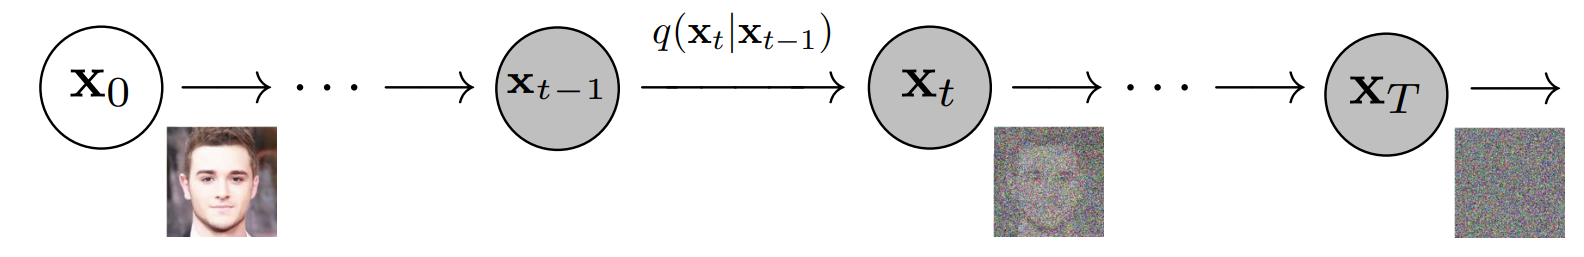

### UNet

The UNet's job is to learn the noise distribution. In particular, it aims to learn the noise added in each time step by reversing the process during the reverse diffusion process. An example of a U-Net architecture is shown below (Credits: https://www.geeksforgeeks.org/u-net-architecture-explained/). This architecture consists of several convolutional blocks to downsample, or decrease the image size, and convolutional transpose blocks to upsample, or increase the image size.

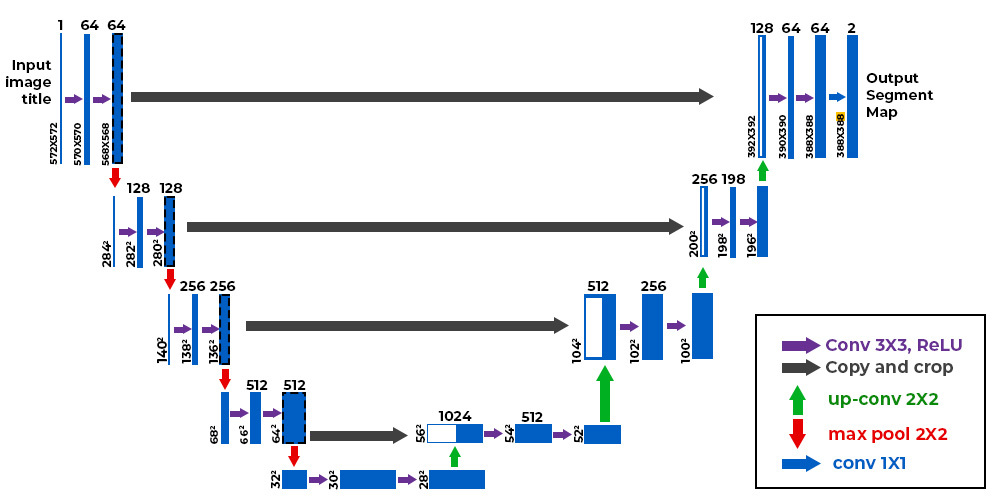

Below is an illustration of convolutional layers vs. convolutional tranpose layers. (Credits: https://hannibunny.github.io/mlbook/neuralnetworks/convolutionDemos.html)

**Convolutional Layer:** No padding of the image, stride of 1.

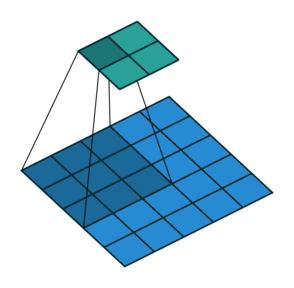

**Convolutional Layer:** Padding of the image, stride of 1.

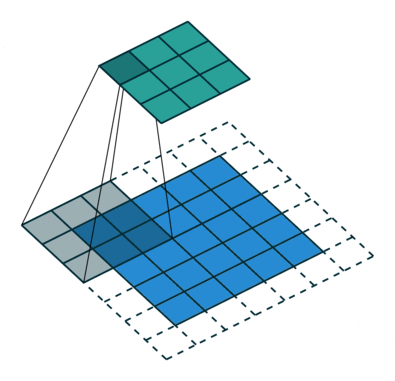

**Convolutional Transpose:** No padding of the image, stride of 1. (automatic increase in size the kernel runs over)

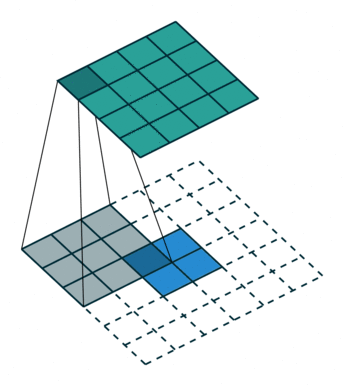

**Convolutional Transpose:** Padding of the image itself, stride of 1. (automatic increase in size the kernel runs over)

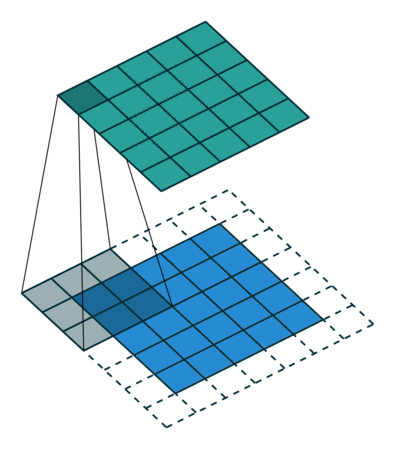

The key is that convolutional layers decrease the image size while convolutional transpose layers increase the image size. Note that convolutional transpose layers do not act as inverses to the convolutional layers.

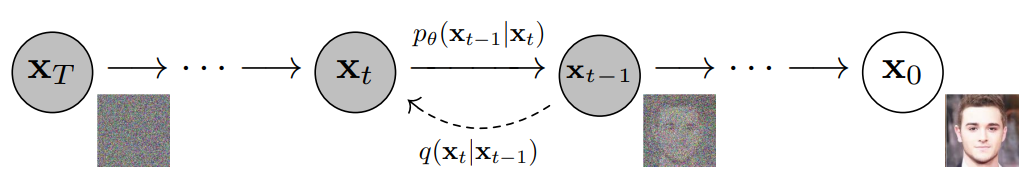

### Loss Function

There are two common ways to construct a loss function for a diffusion model. One way is to iterate the U-Net through all time steps from the noised image to the original image, therefore, the model outputs the cleaned images. In this case, you can use a mean-squared error (MSE) loss between the predicted and true image. A second way to randomly select a time step, construct the noised image at this step, then use the model to predict the noise input to the image at this step. Here, you can use an L1-loss squared or the MSE loss between the true and predicted noise, where information about the time step also must be included in the U-net. In both cases, the model is learning the noise distribution, i.e. how to denoise the images. The loss can be written as
$$L(\varepsilon,\varepsilon_\theta (x_t,t) ) = C\sum_{i,j} (\varepsilon_{ij} - \varepsilon_{\theta,ij} )^2$$
where $C$ is a constant.


# Other Resources



1.   Diffusion Models Beat GANs on Image Synthesis (OpenAI, 2021) https://arxiv.org/abs/2105.05233
2.   What are Diffusion Models? (Lilian Weng, 2021) https://lilianweng.github.io/posts/2021-07-11-diffusion-models/
3. Diffusion Models from Scratch in PyTorch: https://www.youtube.com/watch?v=a4Yfz2FxXiY
4. Transposed Convolution: https://www.youtube.com/watch?v=96_oGE8WyPg

